In [25]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
destination_test_file = "/content/drive/MyDrive/projects/stock-market-sentiment/deepseek/v2/annotated_test.csv"

X_test = pd.read_csv(destination_test_file)

In [27]:
X_test

,text,label_text,deep_seek_v3_reason,deep_seek_v3_label_text,deep_seek_v3_label
0,"O novo acordo, que expande uma cooperação de l...",positive,The expansion of a long-term cooperation and t...,positive,1
1,(ADP News) - A fornecedora finlandesa de siste...,positive,The announcement of new orders worth EUR 10 mi...,positive,1
2,A maior fabricante de papel para revistas do m...,positive,The closure of less competitive factories and ...,positive,1
3,"a 11 de janeiro de 2010, a diretoria da EPHC a...",positive,The approval of a dividend increase typically ...,positive,1
4,"Com esta nomeação, o Kaupthing Bank visa coord...",positive,The text mentions the bank's intention to coor...,neutral,0
...,...,...,...,...,...
295,A unidade de conectividade tem mais de 100 cli...,neutral,The text highlights a significant number of cl...,positive,1
296,O total máximo de negociações obrigatórias por...,neutral,The text provides a factual statement about th...,neutral,0
297,Comunicado à bolsa de valores da Vaisala Oyj 2...,neutral,The text reports the approval of the company's...,neutral,0
298,A maior parte dos dividendos irá para a famíli...,neutral,The text mentions that most dividends will go ...,neutral,0


In [28]:
from transformers import pipeline

In [29]:
from google.colab import userdata
# Use a pipeline as a high-level helper
classifier = pipeline("text-classification",
                model="winderfeld/bert-portuguese-deepseek-sentiment-analysis",
                token = userdata.get('HF_TOKEN'))

Device set to use cpu


In [30]:
def add_model_predictions(df, classifier, new_column_name):
    """
    Add model predictions to the DataFrame in a new column.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing the text data
    classifier : callable
        The classifier function that takes a text input and returns a prediction
    new_column_name : str
        The name of the new column to store predictions

    Returns:
    --------
    pandas.DataFrame
        DataFrame with the new predictions column
    """
    df = df.copy()

    df[new_column_name] = None

    for idx in df.index:
        try:
            text = df.loc[idx, 'text']
            prediction = classifier(text)

            label = df.loc[idx, 'label_text']
            prediction_label = prediction[0].get('label')

            df.loc[idx, new_column_name] = prediction_label

        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            continue

    return df

In [31]:
results_df = add_model_predictions(X_test, classifier, 'Bert_FT_label_text')

In [35]:
from sklearn.metrics import accuracy_score

deep_seek_v3 = accuracy_score(results_df['label_text'], results_df['deep_seek_v3_label_text'])
ft_roberta = accuracy_score(results_df['label_text'], results_df['Bert_FT_label_text'])
deep_seek_v3, ft_roberta

(0.7866666666666666, 0.78)

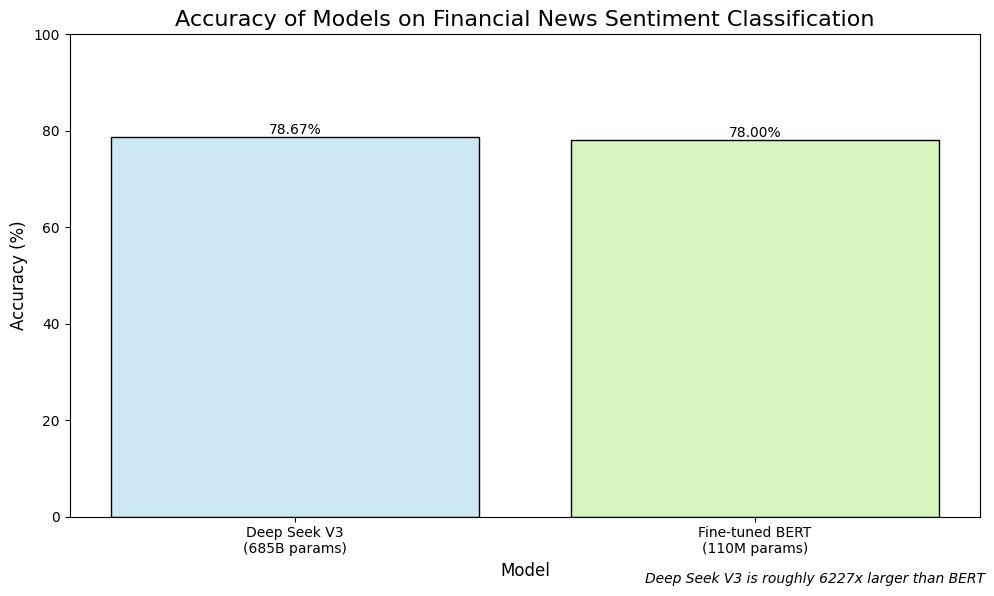

In [36]:
import matplotlib.pyplot as plt

models = ['Deep Seek V3\n(685B params)', 'Fine-tuned BERT\n(110M params)']
accuracies = [deep_seek_v3, ft_roberta]

percentages = [acc * 100 for acc in accuracies]

sorted_data = sorted(zip(models, percentages), key=lambda x: x[1], reverse=True)
sorted_models, sorted_percentages = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_models, sorted_percentages, color=['#cde8f4', '#d6f5bf'], edgecolor='black', linewidth=1)

plt.title("Accuracy of Models on Financial News Sentiment Classification", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:.2f}%',
             ha='center', va='bottom')

plt.figtext(0.99, 0.02, f'Deep Seek V3 is roughly {round(685000 / 110)}x larger than BERT',
            ha='right', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

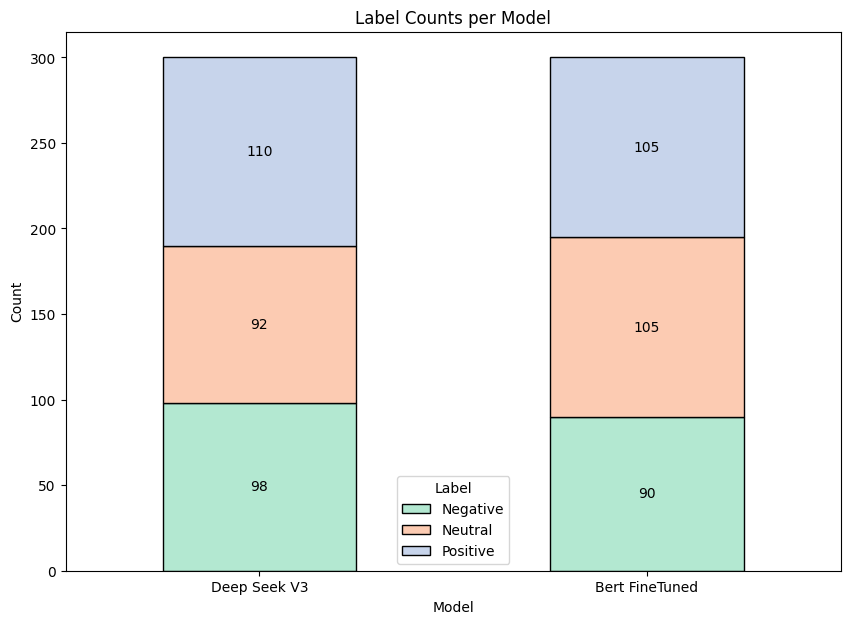

In [37]:
models = {
    'Deep Seek V3': 'deep_seek_v3_label_text',
    'Bert FineTuned': 'Bert_FT_label_text',
}

# Calculating counts
label_counts = {model: {'negative': 0, 'neutral': 0, 'positive': 0} for model in models.keys()}
for model, column in models.items():
    label_counts[model]['neutral'] = results_df[results_df[column] == 'neutral'].shape[0]
    label_counts[model]['positive'] = results_df[results_df[column] == 'positive'].shape[0]
    label_counts[model]['negative'] = results_df[results_df[column] == 'negative'].shape[0]

counts_df = pd.DataFrame(label_counts).T

ax = counts_df[['negative', 'neutral', 'positive']].plot(
   kind='bar',
   stacked=True,
   figsize=(10, 7),
   color=['#b3e8d1', '#fccbb2', '#c7d4eb'],
   edgecolor='black'
)

for p in ax.patches:
   width, height = p.get_width(), p.get_height()
   x, y = p.get_xy()
   ax.text(x + width/2,
           y + height/2,
           f'{int(height)}',
           ha='center',
           va='center')

plt.title('Label Counts per Model')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label', labels=['Negative', 'Neutral', 'Positive'])
plt.show()